# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [355]:
#!pip install pycrf
#!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import random
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import sklearn_crfsuite as CRF

from sklearn_crfsuite import metrics

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

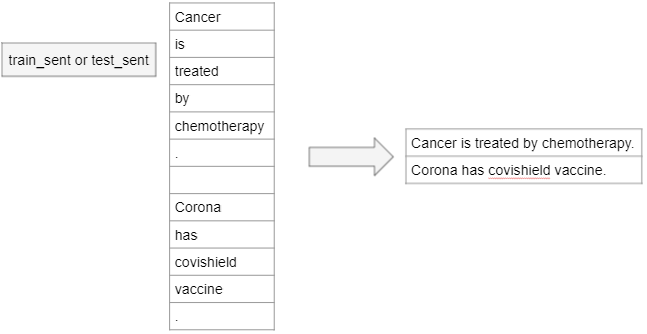

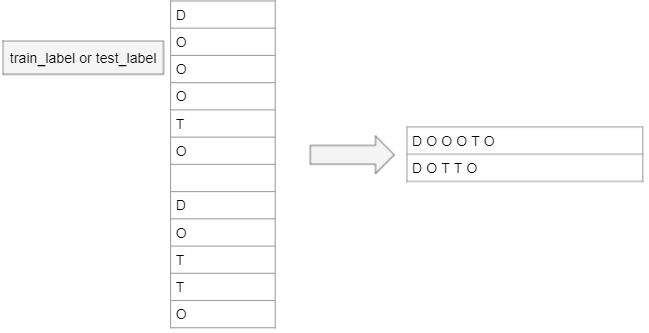

In [6]:
with open('dataset/train_sent', 'r') as train_sent_file:
  train_words_raw = train_sent_file.readlines()

with open('dataset/train_label', 'r') as train_labels_file:
  train_labels_raw = train_labels_file.readlines()

with open('dataset/test_sent', 'r') as test_sent_file:
  test_words_raw = test_sent_file.readlines()

with open('dataset/test_label', 'r') as test_labels_file:
  test_labels_raw = test_labels_file.readlines()

In [7]:
# Print the 6th sentence in the test set i.e. index value 5.
print(train_words_raw[5])

# Print the labels of this sentence
print(train_labels_raw[5])

=

O



In [12]:
import re
## Function to create sentences from list of words
def process_word_list(word_list):
    sentence_list = []
    sentence= ""
    for word in word_list:
        #print (word)
       
        if (re.search('^\s+$',word)) : 
            sentence_list.append(sentence)
            #print("*"+sentence)
            sentence=""
        else:
             sentence= sentence+word.strip()+" "
    return sentence_list     

In [13]:
train_sentences = process_word_list(train_words_raw)
test_sentences = process_word_list(test_words_raw)
train_labels = process_word_list(train_labels_raw)
test_labels = process_word_list(test_labels_raw)

In [20]:
for i in range(5):
    sampler  = random.randint(0,len(train_sentences)-1)
    print(train_sentences[sampler])
    print(train_labels[sampler])

Dual leadership in complex organizations 
O O O O O 
Evidence-based medicine and general practice 
O O O O O 
Inferences from symphysiotomy experience 
O O T O 
Basal and stimulated acid concentrations also increased ( 29.1 +/- 36.6 to 54 +/- 31 mmol/l and 72.5 +/- 46 to 120.1 +/- 30 mmol/l , respectively , for basal and stimulated acid concentrations ; P & # 60 ; 0.05 for peak and MAO , P = 0.07 for BAO ) 
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 
Long-term therapy with long-acting octreotide ( Sandostatin-LAR ) for the management of acromegaly 
O O O T T T T T O O O O D 


### Count the number of sentences in the processed train and test dataset 

In [21]:
len(train_sentences)

2599

In [22]:
len(test_sentences)

1056

### Count the number of lines of labels in the processed train and test dataset.

In [16]:
len(train_labels)

2599

In [17]:
len(test_labels)

1056

## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



In [31]:
### For data exploration we will merge the train and test datasets
explore_sentences= []
explore_labels = []
explore_sentences.extend(train_sentences)
explore_sentences.extend(test_sentences)
explore_labels.extend(train_labels)
explore_labels.extend(test_labels)
print(len(explore_sentences))
print(len(explore_labels))
print(explore_sentences[0:3])

3655
3655
['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status ) ', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 ) ', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 ) ']


### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [32]:
#check the pipeline
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7f90231ac5e0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7f9024aaf4a0>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7f9024767460>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7f90248466c0>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7f9024843240>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7f90231a82e0>)]

In [35]:
#We will disable the parser, ner as we do not require it for Concept identification
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])

In [69]:
lemma = []
text = []
pos = []
dep = []
shape =[]

# print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
           # token.shape_, token.is_alpha, token.is_stop)
def get_tags(sent):
    for sent in tqdm(explore_sentences):
        doc = nlp(sent)
        for tok in doc:
            #if tok.pos_=="NOUN" or tok.pos_=="PROPN":
               # nouns_lemma.append(tok.lemma_.lower())
               # nouns_orig.append(tok_)
            text.append(tok.text.lower())
            lemma.append(tok.lemma_.lower())
            pos.append(tok.pos_.lower())
            dep.append(tok.dep_.lower())
            shape.append(tok.shape_.lower())
    
        
        


100%|██████████| 3655/3655 [00:08<00:00, 410.69it/s]


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [71]:
#Analyse the Data before we do concept analysis
token_df = pd.DataFrame({'text':text,'lemma':lemma,'pos':pos, 'dep':dep, 'shape':shape})
token_df.head()

,text,lemma,pos,dep,shape
0,all,all,det,,xxx
1,live,live,adj,,xxxx
2,births,birth,noun,,xxxx
3,>,>,x,,>
4,or,or,cconj,,xx


<AxesSubplot:>

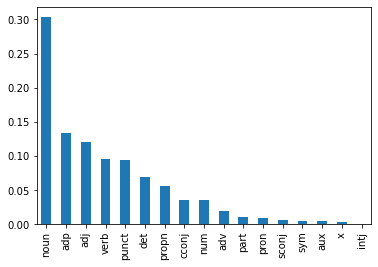

In [78]:
token_df.pos.value_counts(normalize=True).plot.bar()


In [83]:
spacy.explain('adp')

**Observation** 
Around 30% or the words are Nouns, followed Adverbs and Adjective

In [101]:
token_df.pos.isin(['noun'])

0        False
1        False
2         True
3        False
4        False
         ...  
67902     True
67903    False
67904    False
67905    False
67906     True
Name: pos, Length: 67907, dtype: bool

In [119]:
#filter by only Nouns and Proper Nouns

token_df_f= token_df.loc[token_df.pos.isin(['noun','propn'])]

In [127]:
token_df_f.groupby(by=['pos'], sort=True).

,text,lemma,dep,shape
pos,,,,
noun,20624,20624,20624,20624
propn,3789,3789,3789,3789


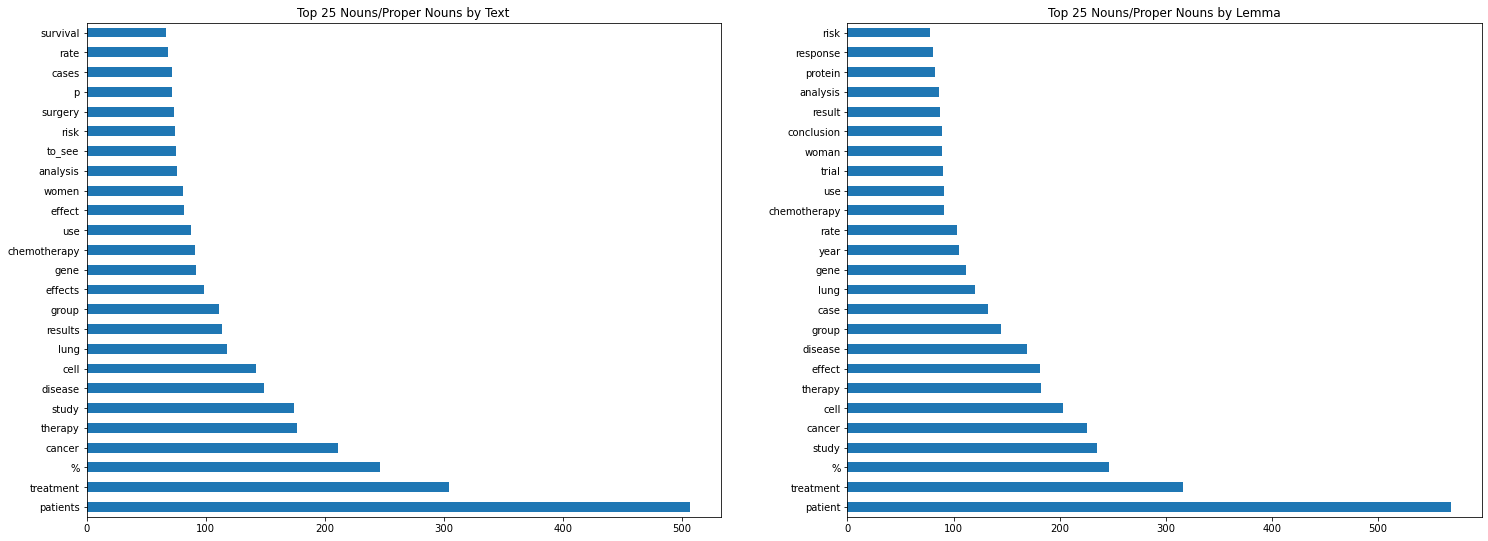

In [157]:
plt.figure(figsize=(25, 20))
fig = plt.subplot(2,2,1)
plt.title("Top 25 Nouns/Proper Nouns by Text")
token_df_f.text.value_counts().head(25).plot(kind='barh' )
plt.subplot(2,2,2)
plt.title("Top 25 Nouns/Proper Nouns by Lemma")
token_df_f.lemma.value_counts().head(25).plot(kind='barh')
plt.show()

**Observation** - Lemmas are more meaningful, and can be used further. 

In [391]:
token_df_f.lemma.value_counts().tail(25)

retention             1
depress               1
radiosterilization    1
homophobia            1
repolarization        1
serotype              1
town                  1
pancrea               1
pyloroplasty          1
hemostasis            1
seminoma              1
left                  1
colostral             1
leukapheresis         1
sugar                 1
homocystinuria        1
idarubicin            1
rs                    1
house                 1
verapamil             1
lectureship           1
p=.013                1
amyloidose            1
dental                1
shark                 1
Name: lemma, dtype: int64

## Defining features for CRF





In [215]:
#Convert the train_sentences to their lemmas
train_sentences_lemma=[]
for sent in tqdm(train_sentences):
    doc = nlp(sent)
    train_sentences_lemma.append(" ".join([token.lemma_ for token in doc]))
        

100%|██████████| 2599/2599 [00:05<00:00, 495.78it/s]


In [389]:
#Explore Disease Names and Treatment Names for computing Features
def print_samples(data,labels, no_of_samples):
    sample_seq = random.sample(range(len(data)-1),no_of_samples)
    disease_list=[]
    treatment_list=[]
    for sample_no in sample_seq:
        sentence=data[sample_no]
        label=labels[sample_no]
        #print("Sample Number is {}".format(sample_no))
        #print(sentence)
        #print(label)
        for word, label in zip(sentence.split(),label.split()):
            if (label=='D'):
              disease_list.append(word)
            if (label=='T'):
              treatment_list.append(word)
    print("*"*10+"DISEASE LIST"+"*"*10)
    print(disease_list)
    print("*"*10+"TREATMENT LIST"+"*"*10)
    print(treatment_list)
                
        
        

In [217]:
print_samples(train_sentences_lemma, train_labels,100)

**********DISEASE LIST**********
['spinal', 'subdural', 'hematoma', 'recurrent', 'anterior', 'dislocation', 'of', 'the', 'shoulder', 'bowel', 'perforation', 'lung', 'carcinoma', 'preeclampsia', 'primary', 'infertility', 'surgery', 'in', 'advanced', 'epithelial', 'acute', 'lymphoblastic', 'leukemia', 'and', 'non', '-', '-', 'normal', '-', 'septic', 'arthritis', 'preterm', 'PROM', 'treatment', 'nsclcm', 'soft', 'tissue', 'sarcoma', 'polio', 'intractable', ',', 'nonmalignant', 'pain', 'symptom', 'attributable', 'to', 'the', 'paranasal', 'sinus', 'coronary', 'event', 'esophageal', 'cancer', 'involve', 'the', 'tracheobronchus', 'reduction', 'for', 'hypertrophic', 'cold', 'symptom', 'suppression', 'cancer', 'risk', 'gunshot', 'wound', 'asthma', 'hypoalbuminemic', 'cachectic', 'cancer', 'Measles', 'malignant', 'pleural', 'effusion', 'steroid', '-', 'refractory', '(', 'rt', ')', 'for', 'non', '-', 'closed', 'head', 'injury', 'hydatid', 'disease', '%', 'germ', 'cell', 'tumor', 'allergy', 'hepat

In [221]:
#Get  Tags for Feature

def getNLPTag(sent, tag_type='POS'):
    tagged_feature = {}
    doc = nlp(sent)
    for i,tok in enumerate(doc):
        #if tok.pos_=="NOUN" or tok.pos_=="PROPN":
           # nouns_lemma.append(tok.lemma_.lower())
           # nouns_orig.append(tok_)
        if (tag_type=="POS"):
            tagged_feature[i]=tok.pos_.lower()
        elif (tag_type=="LEMMA"):
            tagged_feature[i]=tok.lemma_.lower()
        elif (tag_type=="SHAPE"):
            tagged_feature[i]=tok.shape_.lower()
        else:
            tagged_feature[i]=tok.text.lower()
    
    return tagged_feature

In [237]:
# Let's define the features to get the feature value for one word.


#Define a function to get the above defined features for a word.

def getFeaturesForOneWord(sentence, pos, feature_dict):
  word = sentence[pos]
  pos_tag=feature_dict['POS']
  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-4:]=' + word[-2:],     # last four characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.containsSpchar=%s' % re.search("['-/']+",word), #word is having few delimeters which indicate its a D
    'word.postag=%s'% pos_tag[pos]               
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_words.startsWithCapital=%s' % prev_word[0].isupper(),
    'prevword.postag=%s'% pos_tag[pos-1]  
  ])
  else:
    features.append('BEG') # feature to track begin of sentence 

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [238]:
# Write a code to get features for a sentence.

def getFeaturesForOneSentence(sentence):
  feature_dict ={}
  feature_dict['POS'] =  getNLPTag(sentence, "POS")
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos, feature_dict) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [239]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

In [240]:
example_sentence = train_sentences[30]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The survey indicated a variety of thermal care styles 


['word.lower=indicated',
 'word[-3:]=ted',
 'word[-4:]=ed',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'word.containsSpchar=None',
 'word.postag=verb',
 'prev_word.lower=survey',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=False',
 'prevword.postag=noun']

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [241]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]

X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

### Define the labels as the target variable for test and the train dataset

In [242]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]

X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

## Build the CRF Model

In [243]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, Y_train)


/Users/r0r00i9/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(keep_tempfiles=None, max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [244]:
# Calculate the f1 score using the test data
Y_pred = crf.predict(X_test)


### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [246]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9075298677658681

In [358]:
#Trying to optimize few parameters

#Creating the CRF model
crf = sklearn_crfsuite.CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)
crf.fit(X_train, Y_train)

# Calculate the f1 score using the test data
Y_pred = crf.predict(X_test)

In [359]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9201382680323412

In [387]:
#Trying to optimize few parameters

#Creating the CRF model
crf = sklearn_crfsuite.CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=1000,
          all_possible_transitions=False)
crf.fit(X_train, Y_train)

# Calculate the f1 score using the test data
Y_pred = crf.predict(X_test)
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9228711444515967

In [360]:
# Print the orginal labels and predicted labels for the sentence  in test data, which is at index value 10.
id = 26
print("Sentence:",test_sentences[id])
print("Orig Labels:", Y_test[id])
print("Pred Labels:", Y_pred[id])

for i in range(5):
    id  = random.randint(0,len(test_sentences)-1)
    print("Sentence:",test_sentences[id])
    print("Orig Labels:", Y_test[id])
    print("Pred Labels:", Y_pred[id])

Sentence: Chromosome 12 gave the strongest and most consistent results with a peak multipoint MLS of 3.5 , suggesting that this region contains a new susceptibility gene for AD 
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Sentence: In contrast , on language development testing , 19 children demonstrated receptive language delay 
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Sentence: Analysis of five mutations in 20 mucopolysaccharidois type 1 patients : high prevalence of the W402X mutation 
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O'

## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

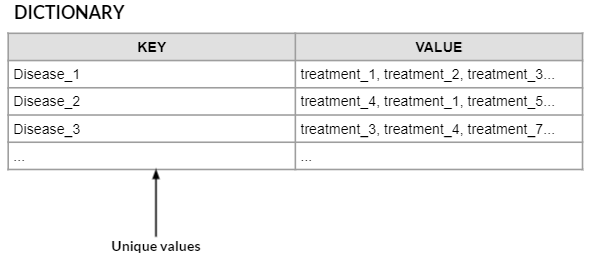

In [381]:
def group_disease_treatment(test_sentences, test_labels):
    disease_map=defaultdict(list)
    for sentence, label_s in zip(test_sentences,test_labels):
        
        treatment_list= []
        disease = ""
        for word, label in zip(sentence.split(), label_s.split()):
           # print (word, label)
            if (label=='D'):
                disease = disease+" "+word
                                  
            if (label =='T'):
                treatment_list.append(word)
                #print("T"+word)
        
        if(disease != ""):
            if (disease not in disease_map.keys()  ):
                print ("Adding"+disease)
                disease_map[disease]=""
            elif (disease in disease_map.keys()):
                 print("Getting :"+disease)
                 if (len(treatment_list)>0) :
                    treatment_list_app= []
                    treatment_list_app = list(disease_map.get(disease))
                    print("Treatment List b/f {}".format(treatment_list_app))
                    print("Treatment List to add {}".format(treatment_list))
                    treatment_list_app.extend(treatment_list)
                    disease_map[disease]=treatment_list_app
                    print("Treatment List a/f {}".format(disease_map[disease]))
                 else:
                    print("No Treatment found")
        #Treatment present disease is not found
        elif (len(treatment_list)>0):
            print("No disease found for treatment {}".format(treatment_list))
                    
       
                
    return disease_map

In [382]:
disease_map = group_disease_treatment(test_sentences, test_labels)

Adding autosomal trisomies
Adding cytogenetic aberrations
Adding Trisomy 18 microcephaly spina bifida nonimmune hydrops fetalis
Adding preeclampsia
Getting : preeclampsia
No Treatment found
Adding hypotonia hepatosplenomegaly ascites
Adding hemiplegia
Adding hematoma lucencies nonimmune hydrops fetalis
Adding cancer
Adding breast cancer breast cancer ovarian cancer
Adding prostate cancer
Adding prostate cancers
Getting : prostate cancer
No Treatment found
Getting : prostate cancer
No Treatment found
Adding multiple sclerosis ( MS )
Adding parvovirus pericardial effusions
Adding deafness
No disease found for treatment ['methylphenidate']
Adding epilepsy ADHD
Adding myocardial infarction
No disease found for treatment ['aspirin', 'warfarin', 'aspirin', 'warfarin', 'aspirin']
Adding unstable angina non-Q-wave myocardial infarction
Adding coronary-artery disease
No disease found for treatment ['surgery', 'radiotherapy']
Adding cervical carcinoma
Adding colon tumors
Adding cerebral palsy
No

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [383]:
disease_df = pd.DataFrame(disease_map.items(), columns=['disease','treatment'])
disease_df

,disease,treatment
0,autosomal trisomies,
1,cytogenetic aberrations,
2,Trisomy 18 microcephaly spina bifida nonimmun...,
3,preeclampsia,
4,hypotonia hepatosplenomegaly ascites,
...,...,...
417,chronic renal failure,
418,vasoreactivity thrombogenicity,
419,total peripheral artery occlusions,
420,multiple myeloma,


In [384]:
disease_df.disease.value_counts()

 stage iii nsclc                           1
 edema                                     1
 cancers cancer                            1
 primary sclerosing cholangitis ( PSC )    1
 stress urinary incontinence               1
                                          ..
 nsclc                                     1
 acoustic neuroma                          1
 glaucoma                                  1
 Blastocystis hominis infection            1
 asthma                                    1
Name: disease, Length: 422, dtype: int64

In [385]:
disease_df.loc[disease_df.disease.apply(lambda x : x.find('her')>0)]

,disease,treatment
147,severe accidental hypothermia,
175,Kaposi sarcoma-associated herpesvirus infection,
278,toxic effects of chemotherapy and radiotherapy,
344,large midline incisional hernias,
372,midline incisional hernias,
419,total peripheral artery occlusions,
